In [115]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sn
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
import warnings
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
from warnings import filterwarnings
filterwarnings('ignore')


In [ ]:
# Path of file to read
data_path = 'CollegeBasketballPlayers2009-2021.csv'
total_ball_data = pd.read_csv(data_path, low_memory = False)
total_ball_data = total_ball_data.drop(['ht', 'yr', 'num', 'pid', 'type', 'Rec Rank', 'gbpm', 'ogbpm', 'dgbpm', 'Unnamed: 64', 'Unnamed: 65'], axis=1)


Zmiana zmiennej objasnianej 'pick' na zmienna binarna i filtracja danych

In [19]:
#Przerabiam dane - zmienną objasniana pick przerabiam na binarną
total_ball_data["pick"] = total_ball_data["pick"].replace(np.nan, 0)
for i in range(len(total_ball_data)):
    if total_ball_data["pick"][i] >=1:
        total_ball_data["pick"][i]=1

total_ball_data['pick'] = total_ball_data['pick'].astype(int)

#filtruje przez te 3 kolumny zeby nie stracic zbyt duzej liczby zmiennych objasniajacych 
# w ten sposob tracę 9 a nie 34 zmiennych objasniajacych
total_ball_data =total_ball_data[total_ball_data['drtg'].notna()]
total_ball_data =total_ball_data[total_ball_data['ast'].notna()]
total_ball_data =total_ball_data[total_ball_data['dunksmade'].notna()]

total_ball_data['rimmade/(rimmade+rimmiss)'].fillna(0, inplace=True)
total_ball_data['midmade/(midmade+midmiss)'].fillna(0, inplace=True)
total_ball_data['dunksmade/(dunksmade+dunksmiss)'].fillna(0, inplace=True)
total_ball_data['ast/tov'].fillna(0, inplace=True)

total_ball_data = total_ball_data._get_numeric_data()

Na danych do 2020 roku włącznie uczę model. Na danych z 2021 dokonam weryfikacji modelu. 

In [21]:
ball_data = total_ball_data.loc[total_ball_data['year'] < 2021]
ball_data = ball_data.drop(['year'], axis=1)
ball_data_2021 = total_ball_data.loc[total_ball_data['year'] == 2021]
ball_data_2021 = ball_data_2021.drop(['year'], axis=1)
total_ball_data = total_ball_data.drop(['year'], axis=1)
#ball_data

In [36]:
def conf_matrix(val_y, pred_test):    
    # Creating a confusion matrix
    con_mat = confusion_matrix(val_y, pred_test)
    con_mat = pd.DataFrame(con_mat, index=['Not Drafted', 'Drafted'], columns=['Not Drafted', 'Drafted'])
    
    # Plotting the confusion matrix
    plt.figure(figsize=(6, 6))
    sn.set(font_scale=1.5)
    sn.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Adding labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

Wszystkie 45 zmiennych

In [23]:
# Creates a target object for the pick and calls it y
y = ball_data.pick

# Creates X by using specific statistics
#features = ['Min_per', 'ftr', 'pts', 'ORB_per', 'DRB_per', 'blk_per', 'stl_per', 'dporpag', 'porpag', 'AST_per', 'TO_per', 'FT_per']

X = ball_data.loc[:,ball_data.columns!='pick']

colnames=list(X)
#display(X)
#X = ball_data[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

Validation f1 score: 0.24629
Validation recall score: 0.87578
Validation presision score: 0.14329


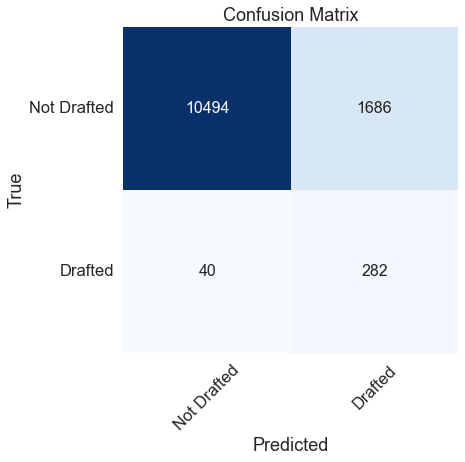

In [47]:
model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

model.fit(train_X, train_y)

y_pred = model.predict(val_X)

f1 = f1_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
print("Validation f1 score: {:,.5f}".format(f1))
print("Validation recall score: {:,.5f}".format(recall))
print("Validation presision score: {:,.5f}".format(precision))
 
conf_matrix(val_y, y_pred)


Validation f1 score: 0.13764
Validation recall score: 1.00000
Validation presision score: 0.07391


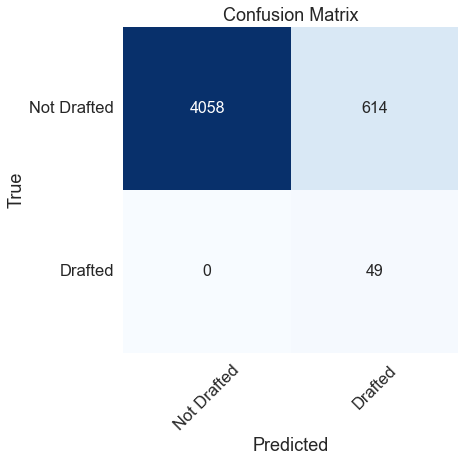

In [48]:
# Test data, using 2021
test_X_2021 = ball_data_2021[colnames]

# Make predictions
test_preds_2021 = model.predict(test_X_2021)

f1 = f1_score(ball_data_2021.pick, test_preds_2021)
recall = recall_score(ball_data_2021.pick, test_preds_2021)
precision = precision_score(ball_data_2021.pick, test_preds_2021)
print("Validation f1 score: {:,.5f}".format(f1))
print("Validation recall score: {:,.5f}".format(recall))
print("Validation presision score: {:,.5f}".format(precision))
 
conf_matrix(ball_data_2021.pick, test_preds_2021)

# Save predictions in right format
#output = pd.DataFrame({'Name': ball_data_2021.player_name, 'Pick': test_preds_2021, 'Actual Pick' : ball_data_2021.pick})
#output = output.astype({'Pick':'int'})
#output = output.astype({'Actual Pick':'int'})
#output.to_csv('predictions2021.csv', index=False)
#output

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Text(0.5, 1.0, 'Scoring for different class weights')

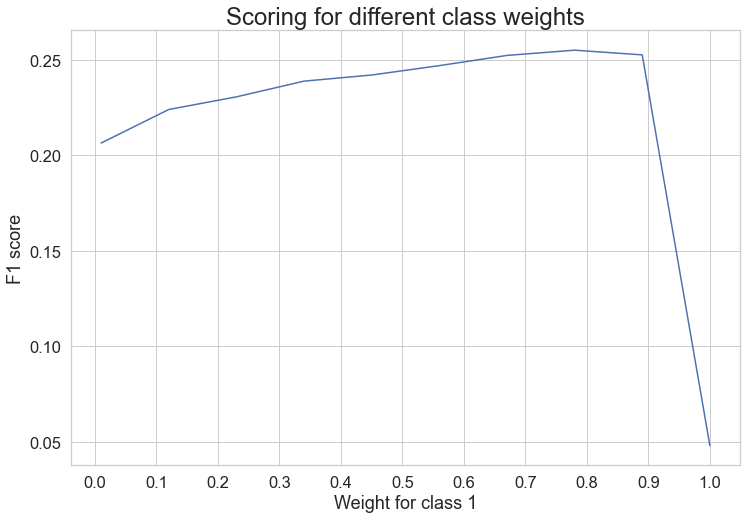

In [42]:
#Setting the range for class weights
weights = np.linspace(0.0,0.99,10)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= model, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(train_X, train_y)

#Ploting the score for different values of weight
sn.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sn.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)
# Get the index of the highest F1 score
best_index = gridsearch.best_index_

# Get the corresponding weight values for weight one and weight two
best_weight_one = 1 - weights[best_index]
best_weight_two = weights[best_index]

# Get the highest F1 score
best_f1_score = gridsearch.cv_results_['mean_test_score'][best_index]

# Print the results
print("Highest F1 Score:", best_f1_score)
print("Weight for Class 1:", best_weight_one)
print("Weight for Class 2:", best_weight_two)

Nowy model dla nowych wag

Validation f1 score: 0.37273
Validation recall score: 0.25466
Validation precision score: 0.69492


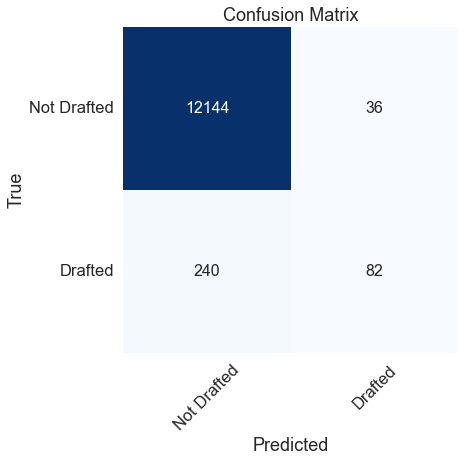

In [117]:
model = RandomForestClassifier(class_weight={0: 0.78, 1: 0.22})
# Fit the model with the specified class weights
model.fit(train_X, train_y)
y_pred = model.predict(val_X)

f1 = f1_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
print("Validation f1 score: {:,.5f}".format(f1))
print("Validation recall score: {:,.5f}".format(recall))
print("Validation precision score: {:,.5f}".format(precision))
 
conf_matrix(val_y, y_pred)


Validation f1 score: 0.32353
Validation recall score: 0.22449
Validation presision score: 0.57895


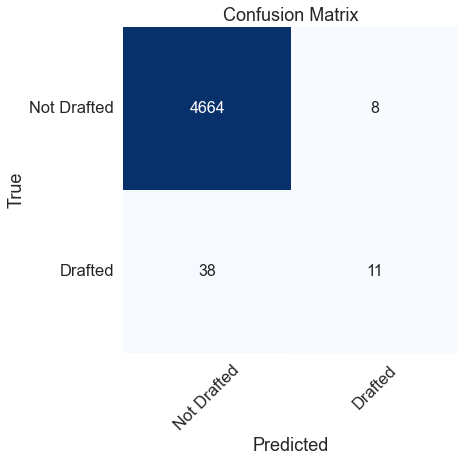

In [50]:
# Test data, using 2021
test_X_2021 = ball_data_2021[colnames]

# Make predictions
test_preds_2021 = model.predict(test_X_2021)

f1 = f1_score(ball_data_2021.pick, test_preds_2021)
recall = recall_score(ball_data_2021.pick, test_preds_2021)
precision = precision_score(ball_data_2021.pick, test_preds_2021)
print("Validation f1 score: {:,.5f}".format(f1))
print("Validation recall score: {:,.5f}".format(recall))
print("Validation presision score: {:,.5f}".format(precision))
 
conf_matrix(ball_data_2021.pick, test_preds_2021)

Check importance of features in Random Forest Model

    Feature     Score
0         0  0.150252
1         1  0.018884
2         2  0.008979
3         3  0.022111
4         4  0.000000
5         5  0.019726
6         6  0.013352
7         7  0.037942
8         8  0.003124
9         9  0.031726
10       10  0.022563
11       11  0.005763
12       12  0.000000
13       13  0.067118
14       14  0.013761
15       15  0.008651
16       16  0.008895
17       17  0.042738
18       18  0.003233
19       19  0.025698
20       20  0.024277
21       21  0.032236
22       22  0.334709
23       23  0.057738
24       24  0.009358
25       25  0.037169


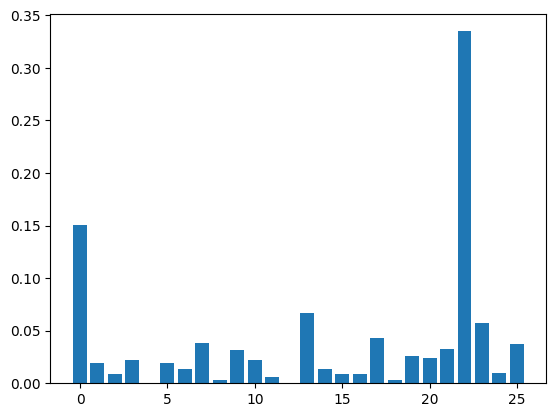

In [382]:
importance = model.feature_importances_
importancedf = pd.DataFrame(columns=['Feature', 'Score'])
for i,v in enumerate(importance):
    #print('Feature: %0d, Score: %.5f' % (i,v))
    importancedf = importancedf.append({'Feature':round(i), 'Score':v}, ignore_index=True)
    importancedf = importancedf.astype({'Feature':'int'})
print(importancedf)
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Choose top 11 features with highest importance


In [383]:
featurelist = list(X)

featuresdf = pd.DataFrame({'Feature': importancedf.iloc[:,0], 'Name': featurelist, 'Score':importancedf.iloc[:,1]})
featuresdf = featuresdf.sort_values(by=['Score'], ascending=False)
featuresdf.head(11)

,Feature,Name,Score
22,22,porpag,0.334709
0,0,GP,0.150252
13,13,twoPM,0.067118
23,23,adjoe,0.057738
17,17,TPA,0.042738
7,7,DRB_per,0.037942
25,25,pid,0.037169
21,21,ftr,0.032236
9,9,TO_per,0.031726
19,19,blk_per,0.025698


In [387]:
# Creates a target object for the pick and calls it y
y = ball_data.pick

# Creates X by using specific statistics
#features = ['gbpm', 'blk_per', 'twoPM', 'bpm', 'pid', 'DRB_per', 'ogbpm', 'ast', 'TPM', 'adjoe', 'Ortg']
features = ['porpag', 'GP', 'twoPM', 'adjoe', 'TPA', 'DRB_per', 'pid', 'ftr', 'TO_per', 'blk_per', 'stl_per']
Xnew = ball_data[features]

# Split into validation and training data
train_Xnew, val_Xnew, train_y, val_y = train_test_split(Xnew, y, random_state=1)

In [388]:
# Specify a Random Forest Model
ball_model = DecisionTreeRegressor(max_leaf_nodes=100, splitter='random', random_state=1, max_features='auto')
# Fit the model
ball_model.fit(train_Xnew, train_y)

# Make predictions on validation data and calculate the mean absolute error
val_preds = ball_model.predict(val_Xnew)
val_mae = mean_absolute_error(val_preds, val_y)
print("Validation MAE: {:,.5f}".format(val_mae))

Validation MAE: 1.38249


In [390]:
# Test data, using 2021
ball_data_2021 = total_ball_data.loc[total_ball_data['year'] == 2021]
test_X_2021 = ball_data_2021[features]

# Make predictions
test_preds_2021 = ball_model.predict(test_X_2021)

# Find MAE
test_mae_2021 = mean_absolute_error(test_preds_2021, ball_data_2021.pick)

print("2021 Test MAE: {:,.5f}".format(test_mae_2021))

# Save predictions in right format
output = pd.DataFrame({'Name': ball_data_2021.player_name, 'Pick': test_preds_2021, 'Actual Pick' : ball_data_2021.pick})
#output.to_csv('predictions2021.csv', index=False)
output = output.astype({'Pick':'int'})
output = output.astype({'Actual Pick':'int'})
output


2021 Test MAE: 0.84331


,Name,Pick,Actual Pick
56091,Troy Holston,0,0
56092,Isaiah Felder,0,0
56093,Thomas Bruce,0,0
56094,Tyler Underwood,0,0
56095,Jalen Coleman-Lands,0,0
...,...,...,...
61056,Trey Patterson,0,0
61057,Stavros Polatoglou,0,0
61058,Sandy Ryan,0,0
61059,Ty Larson,0,0


In [90]:
def plot_feature_importance(model, x_train, n=55):
    # extract and sort the feature importance
    features = model.feature_importances_
    feature_names = x_train.columns.values
    
    # combine the features importance and column names into a matrix and sort them
    feature_matrix = np.array([features, feature_names])
    feature_matrix = feature_matrix.transpose()
    feature_matrix.sort(0)
    
    # divide the column names and feature importance
    sorted_feat = feature_matrix[:, 0]
    sorted_columns = feature_matrix[:, 1]
    
    sn.set(font_scale=1)
     # plot the features
    plt.figure(figsize=(16, 12))
    try:
        plt.barh(sorted_columns[-n:], sorted_feat[-n:], align='center')
    
    except:
        # if n features is greater than the amount that actually exists
        n = len(sorted_feat)
        plt.barh(sorted_columns[-n:], sorted_feat[-n:], align='center')
        
    plt.yticks(sorted_columns[-n:], sorted_columns[-n:])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    return

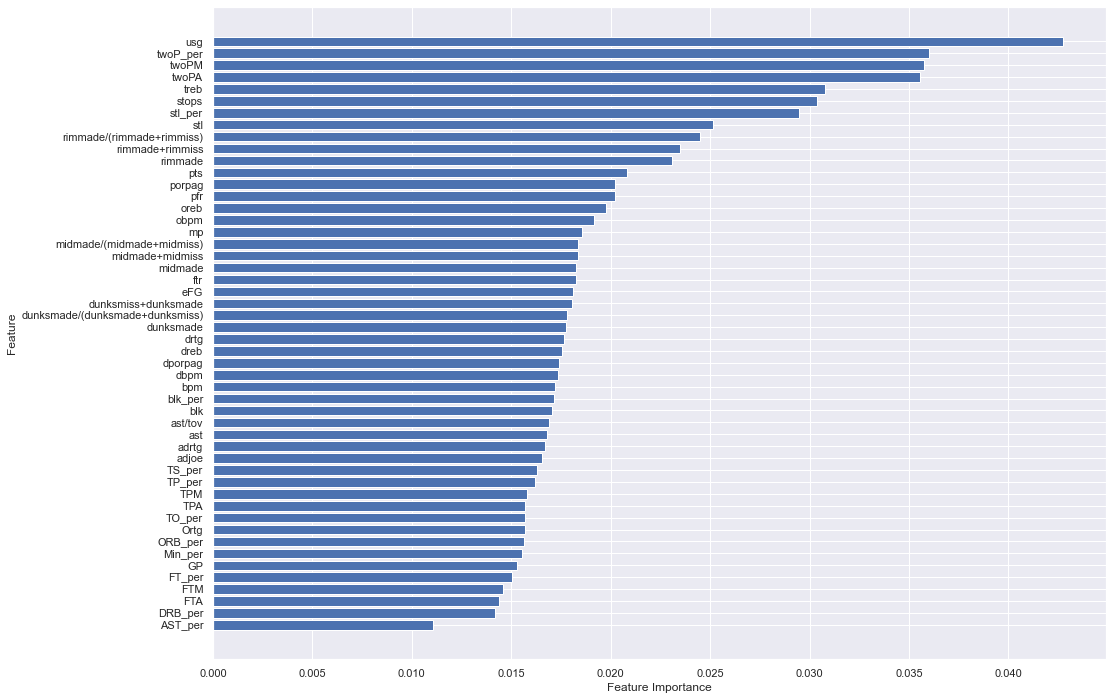

In [91]:
plot_feature_importance(model, train_X)

3rd method - SelectFromModel

In [95]:
#y = ball_data.pick
#model = RandomForestClassifier(n_estimators = 100)
for i in [5,7,9,11]:

    sel = SelectFromModel(model, max_features=i)
    sel.fit(train_X, train_y)
    filter1 = sel.get_support()
    selected_feat= train_X.columns[(filter1)]
    print(len(selected_feat))
    print(list(selected_feat))
    #pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

    train_XX = train_X[list(selected_feat)]
    val_XX = val_X[list(selected_feat)]
    #train_XX, val_XX, train_y, val_y = train_test_split(XX, y, random_state=1)
    #print(train_XX)
    #print(train_y)


    # Specify a Random Forest Model
    #ball_model = DecisionTreeRegressor(max_leaf_nodes=100, splitter='random', random_state=1, max_features='auto')

    # Fit the model
    model.fit(train_XX, train_y)

    # Make predictions on validation data and calculate the mean absolute error
    y_pred = model.predict(val_XX)

    f1 = f1_score(val_y, y_pred)
    recall = recall_score(val_y, y_pred)
    precision = precision_score(val_y, y_pred)
    print("Validation f1 score: {:,.5f}".format(f1))
    print("Validation recall score: {:,.5f}".format(recall))
    print("Validation precision score: {:,.5f}".format(precision))

    # Test data, using 2021
    test_X_2021 = ball_data_2021[list(selected_feat)]

    # Make predictions
    test_preds_2021 = model.predict(test_X_2021)

    f1 = f1_score(ball_data_2021.pick, test_preds_2021)
    recall = recall_score(ball_data_2021.pick, test_preds_2021)
    precision = precision_score(ball_data_2021.pick, test_preds_2021)
    print("2021 f1 score: {:,.5f}".format(f1))
    print("2021 recall score: {:,.5f}".format(recall))
    print("2021 presision score: {:,.5f}".format(precision))

    # Save predictions in right format
    #output = pd.DataFrame({'Name': ball_data_2021.player_name, 'Pick': test_preds_2021, 'Actual Pick' : ball_data_2021.pick})
    #output.to_csv('predictions2021.csv', index=False)
    #output = output.astype({'Pick':'int'})
    #output = output.astype({'Actual Pick':'int'})
    #output


5
['porpag', 'adjoe', 'adrtg', 'dporpag', 'bpm']
Validation f1 score: 0.31555
Validation recall score: 0.21118
Validation precision score: 0.62385
2021 f1 score: 0.25974
2021 recall score: 0.20408
2021 presision score: 0.35714
7
['porpag', 'adjoe', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm']
Validation f1 score: 0.32558
Validation recall score: 0.21739
Validation precision score: 0.64815
2021 f1 score: 0.27692
2021 recall score: 0.18367
2021 presision score: 0.56250
9
['porpag', 'adjoe', 'dunksmade', 'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm']
Validation f1 score: 0.35535
Validation recall score: 0.24224
Validation precision score: 0.66667
2021 f1 score: 0.26087
2021 recall score: 0.18367
2021 presision score: 0.45000
11
['GP', 'porpag', 'adjoe', 'dunksmade', 'dunksmiss+dunksmade', 'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm']
Validation f1 score: 0.35374
Validation recall score: 0.24224
Validation precision score: 0.65546
2021 f1 score: 0.30556
2021 recall score: 0.22449

Wykres walidacji i testu dla MAE

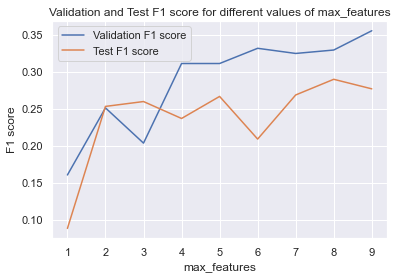

In [100]:
max_features_values = range(1,10)
val_f1_values = []
test_f1_values = []

for i in max_features_values:
    sel = SelectFromModel(model, max_features=i)
    sel.fit(train_X, train_y)
    filter1 = sel.get_support()
    selected_feat= train_X.columns[(filter1)]
    train_XX = train_X[list(selected_feat)]
    val_XX = val_X[list(selected_feat)]
    #XX = ball_data[list(selected_feat)]
    #train_XX, val_XX, train_y, val_y = train_test_split(XX, y, random_state=1)
    #print(train_XX, 'trainXX')
    #print(train_y, 'train_y')
    #ball_model = DecisionTreeRegressor(max_leaf_nodes=100, splitter='random', random_state=1, max_features='auto')
    model.fit(train_XX, train_y)
    y_pred = model.predict(val_XX)
    f1 = f1_score(val_y, y_pred)
    val_f1_values.append(f1)
    # Test data, using 2021
    test_X_2021 = ball_data_2021[list(selected_feat)]
    test_preds_2021 = model.predict(test_X_2021)
    test_f1_2021 = f1_score(ball_data_2021.pick, test_preds_2021)
    test_f1_values.append(test_f1_2021)

plt.plot(max_features_values, val_f1_values, label='Validation F1 score')
plt.plot(max_features_values, test_f1_values, label='Test F1 score')
plt.legend()
plt.xlabel('max_features')
plt.ylabel('F1 score')
plt.title('Validation and Test F1 score for different values of max_features')
plt.show()

kom to u góry: jak widac mae dla validacji waha sie w okolicach 15, ale dla testu jest bardzo zmienny tzn trudno przewidziec tym modelem kto zostanie koszyrzaem NBA.

zestawienie rzeczywistych wartosci z predykcjami, jak widac mae 14 to bardzo duzo i wykresy walidacyjny i testowy sa bardzo rozporoszone czyli model nie jest za dobry - bylby dobry gdyby wykresy mialy ksztalt y=x

In [101]:
print(classification_report(val_y, val_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12180
           1       0.58      0.21      0.31       322

    accuracy                           0.98     12502
   macro avg       0.78      0.61      0.65     12502
weighted avg       0.97      0.98      0.97     12502



Cross validation

In [104]:
log_cv_score = cross_val_score(model, train_X, train_y, cv=3, scoring='f1')
mean_log_cv_score = np.mean(log_cv_score)

print("Mean Cross Validation Score: {:.4}%".format(mean_log_cv_score * 100))

Mean Cross Validation Score: 33.6%


In [105]:
accuracy_score(val_y, y_pred)

0.9768037114061751

In [113]:
log_grid_search = GridSearchCV(model, {'bootstrap': [True,False]}, cv=3, return_train_score=True)
log_grid_search.fit(train_X, train_y)

# Accessing the best estimator and its results
best_estimator = log_grid_search.best_estimator_
cv_results = log_grid_search.cv_results_

log_gs_training_score = np.mean(cv_results['mean_train_score'])
log_gs_testing_score = best_estimator.score(train_X, train_y)

# Predict values based on new parameters
y_pred_acc = best_estimator.predict(val_X)

# New Model Evaluation metrics
print("Mean Training Score:", log_gs_training_score * 100)
print("Mean Testing Score:", log_gs_testing_score * 100)
print('Accuracy Score:', accuracy_score(val_y, y_pred_acc))
print('Precision Score:', precision_score(val_y, y_pred_acc))
print('Recall Score:', recall_score(val_y, y_pred_acc))
print('F1 Score:', f1_score(val_y, y_pred_acc))


Mean Training Score: 99.99866679998613
Mean Testing Score: 100.0
Accuracy Score: 0.9776835706286994
Precision Score: 0.6776859504132231
Recall Score: 0.2546583850931677
F1 Score: 0.3702031602708804


ROC AUC

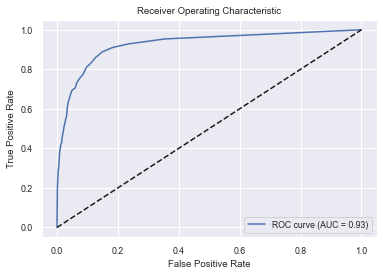

In [120]:
#test set
# Obtain predicted probabilities for positive class
probs = model.predict_proba(val_X)[:, 1]

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(val_y, probs)

# Calculate ROC AUC
roc_auc = roc_auc_score(val_y, probs)
sn.set(font_scale=0.8)
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()